# Refer to SF EDA notebook for Price EDA (Section 5 & 10)

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Import Data

In [3]:
SF_df = pd.read_pickle("pre-processing and EDA/cleaned_price_df.pkl")
SF_df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price_log
0,within an hour,1.0,0.99,1,1,Western Addition,Entire apartment,Entire home/apt,3,1.0,1.0,2.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",132.0,2,30,257,97.0,1.91,4.882802
1,within a day,0.6,0.83,0,2,Bernal Heights,Entire apartment,Entire home/apt,5,1.0,2.0,3.0,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",235.0,30,60,111,98.0,0.81,5.459586
2,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,60,19,84.0,0.14,4.025352
3,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,90,8,93.0,0.11,4.025352
5,within an hour,1.0,0.96,1,2,Mission,Private room in condominium,Private room,3,1.0,1.0,1.0,"[""Heating"", ""Hot water"", ""Children\u2019s book...",169.0,1,14,736,98.0,5.47,5.129899


In [4]:
SF_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 7273
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6848 non-null   object 
 1   host_response_rate      6848 non-null   float64
 2   host_acceptance_rate    6848 non-null   float64
 3   host_is_superhost       6848 non-null   int32  
 4   host_listings_count     6848 non-null   int64  
 5   neighbourhood_cleansed  6848 non-null   object 
 6   property_type           6848 non-null   object 
 7   room_type               6848 non-null   object 
 8   accommodates            6848 non-null   int64  
 9   bathrooms               6848 non-null   float64
 10  bedrooms                6848 non-null   float64
 11  beds                    6848 non-null   float64
 12  amenities               6848 non-null   object 
 13  price                   6848 non-null   float64
 14  minimum_nights          6848 non-null   

# Different column names by datatype list

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = SF_df.select_dtypes(include=numerics).columns.to_list()
bool_columns = SF_df.select_dtypes(include='bool').columns.to_list()
object_columns = SF_df.select_dtypes(include='object').columns.to_list()
print(object_columns)

['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']


In [6]:
SF_df.isnull().sum()

host_response_time        0
host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_listings_count       0
neighbourhood_cleansed    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
reviews_per_month         0
price_log                 0
dtype: int64

# Pearson Correlation for Numeric Columns

In [7]:
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(SF_df[numeric_columns])

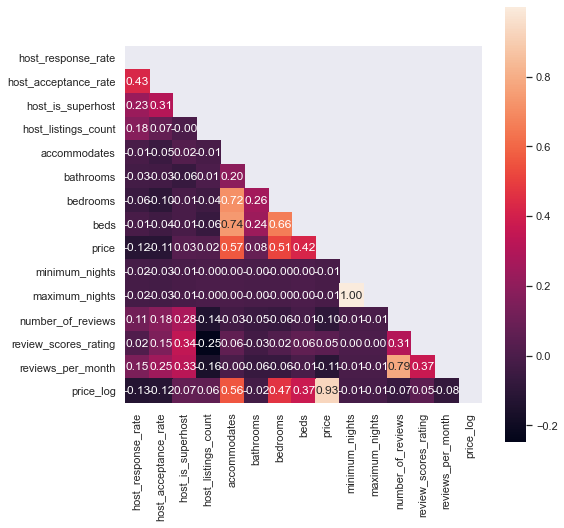

In [8]:
corr = SF_df[numeric_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=numeric_columns, yticklabels=numeric_columns, mask=mask)

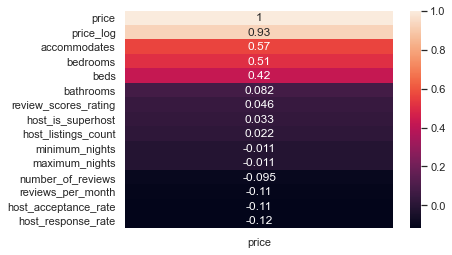

In [9]:
sns.heatmap(corr[['price']].sort_values(['price'],ascending=False),yticklabels=True,annot=True)

# Feature Selection

## Remove features based on Pearson Correlation

In [10]:
new_SF_df = SF_df.drop(columns=['bedrooms','beds','maximum_nights','number_of_reviews'])

In [11]:
print(new_SF_df.columns)

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'amenities',
       'price', 'minimum_nights', 'review_scores_rating', 'reviews_per_month',
       'price_log'],
      dtype='object')


## Remove based on p-values (Backward Elimination)

In [12]:
y = SF_df['price']
X = SF_df[numeric_columns].drop(['price','price_log'], axis =1)

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues.to_frame().reset_index().rename(columns={'index': 'feature', 0: 'p-value'}).sort_values(by='p-value', ascending=False)

,feature,p-value
11,number_of_reviews,7.198979e-01
9,minimum_nights,8.481813e-02
10,maximum_nights,8.471748e-02
8,beds,1.714166e-02
2,host_acceptance_rate,5.174953e-04
12,review_scores_rating,2.732478e-05
4,host_listings_count,6.411037e-07
6,bathrooms,6.969503e-09
3,host_is_superhost,3.032647e-11
13,reviews_per_month,1.800328e-12


In [13]:
#Backward Elimination
cols = list(X.columns)
removed_features_BE = []
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05): # remove if p-value > 0.05
        cols.remove(feature_with_p_max)
        removed_features_BE.append(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print("Selected Features:")
print(selected_features_BE)
print("Removed Features:")
print(removed_features_BE)

Selected Features:
['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'reviews_per_month']
Removed Features:
['number_of_reviews', 'minimum_nights', 'maximum_nights']


In [14]:
for feature in removed_features_BE:
    if feature in new_SF_df.columns:
        new_SF_df.drop(columns=[feature],inplace=True)
print(new_SF_df.columns)
print(len(new_SF_df.columns))

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'amenities',
       'price', 'review_scores_rating', 'reviews_per_month', 'price_log'],
      dtype='object')
15


In [15]:
new_SF_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 7273
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6848 non-null   object 
 1   host_response_rate      6848 non-null   float64
 2   host_acceptance_rate    6848 non-null   float64
 3   host_is_superhost       6848 non-null   int32  
 4   host_listings_count     6848 non-null   int64  
 5   neighbourhood_cleansed  6848 non-null   object 
 6   property_type           6848 non-null   object 
 7   room_type               6848 non-null   object 
 8   accommodates            6848 non-null   int64  
 9   bathrooms               6848 non-null   float64
 10  amenities               6848 non-null   object 
 11  price                   6848 non-null   float64
 12  review_scores_rating    6848 non-null   float64
 13  reviews_per_month       6848 non-null   float64
 14  price_log               6848 non-null   

In [16]:
new_SF_df_copy = new_SF_df

In [17]:
# new_SF_df = new_SF_df_copy

In [18]:
# for col in new_SF_df.columns: 
#     try:      
#         new_SF_df[col] = pd.to_numeric(new_SF_df[col]) 
#         new_SF_df.hist(column=col)
#     except ValueError:
#         print('This column can not be represented as a histogram')

# Data Pre-processing for non-numeric columns

In [19]:
new_SF_df["amenities"] = new_SF_df["amenities"].str.replace('"', "")
new_SF_df["amenities"] = new_SF_df["amenities"].str.replace("[", "")
new_SF_df["amenities"] = new_SF_df["amenities"].str.replace("]", "")

new_SF_df['amenities']

0       Heating, Hot water, Stove, Iron, Dryer, Coffee...
1       Smoke alarm, Heating, Kitchen, First aid kit, ...
2       Host greets you, Heating, Hot water, Kitchen, ...
3       Host greets you, Heating, Hot water, Kitchen, ...
5       Heating, Hot water, Children\u2019s books and ...
                              ...                        
7269    Smoke alarm, Long term stays allowed, Refriger...
7270    Smoke alarm, Long term stays allowed, Refriger...
7271    Gym, Heating, Air conditioning, Iron, Dryer, C...
7272    Gym, Heating, Hot water, Stove, Air conditioni...
7273    Smoke alarm, Refrigerator, Heating, Kitchen, W...
Name: amenities, Length: 6848, dtype: object

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(', '))
amenities = count_vectorizer.fit_transform(new_SF_df['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

In [21]:
len(df_amenities.columns.to_list())

115

In [22]:
df_amenities.columns.to_list()

['air conditioning',
 'alarm system',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'baking sheet',
 'barbecue utensils',
 'bathroom essentials',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bread maker',
 'breakfast',
 'breakfast bar',
 'building staff',
 'cable tv',
 'carbon monoxide alarm',
 'changing table',
 'children\\u2019s books and toys',
 'children\\u2019s dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'cooking basics',
 'crib',
 'desk',
 'dishes and silverware',
 'dishwasher',
 'dryer',
 'dual vanity',
 'elevator',
 'essentials',
 'ethernet connection',
 'ev charger',
 'extra pillows and blankets',
 'fire extinguisher',
 'fireplace guards',
 'first aid kit',
 'free parking on premises',
 'free street parking',
 'full kitchen',
 'game console',
 'garden or backyard',
 'gas fireplace',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'high chair',
 'host greets you',
 'hot tub',
 'hot water',
 

In [23]:
df_amenities

,air conditioning,alarm system,baby bath,baby monitor,babysitter recommendations,baking sheet,barbecue utensils,bathroom essentials,bathtub,bbq grill,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6844,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
6845,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
6846,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0


In [24]:
new_SF_df_wo_amenity_df = new_SF_df.drop(columns=['amenities'])
new_SF_df_wo_amenity_df

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,price,review_scores_rating,reviews_per_month,price_log
0,within an hour,1.0,0.99,1,1,Western Addition,Entire apartment,Entire home/apt,3,1.0,132.0,97.0,1.91,4.882802
1,within a day,0.6,0.83,0,2,Bernal Heights,Entire apartment,Entire home/apt,5,1.0,235.0,98.0,0.81,5.459586
2,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,56.0,84.0,0.14,4.025352
3,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,56.0,93.0,0.11,4.025352
5,within an hour,1.0,0.96,1,2,Mission,Private room in condominium,Private room,3,1.0,169.0,98.0,5.47,5.129899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,within a few hours,1.0,1.00,0,92,Mission,Entire apartment,Entire home/apt,2,1.0,71.0,0.0,0.00,4.262680
7270,within a few hours,1.0,1.00,0,92,Downtown/Civic Center,Entire apartment,Entire home/apt,2,1.0,62.0,0.0,0.00,4.127134
7271,-,0.0,0.00,0,0,Lakeshore,Entire townhouse,Entire home/apt,6,3.0,399.0,0.0,0.00,5.988961
7272,-,0.0,0.00,0,1,South of Market,Private room in apartment,Private room,1,1.0,120.0,0.0,0.00,4.787492


In [25]:
from sklearn import preprocessing
for column in new_SF_df_wo_amenity_df.columns:
    if new_SF_df_wo_amenity_df[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        new_SF_df_wo_amenity_df[column] = le.fit_transform(new_SF_df_wo_amenity_df[column])
        
new_SF_df_wo_amenity_df

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,price,review_scores_rating,reviews_per_month,price_log
0,4,1.0,0.99,1,1,36,3,0,3,1.0,132.0,97.0,1.91,4.882802
1,2,0.6,0.83,0,2,1,3,0,5,1.0,235.0,98.0,0.81,5.459586
2,3,1.0,1.00,0,10,11,19,2,2,4.0,56.0,84.0,0.14,4.025352
3,3,1.0,1.00,0,10,11,19,2,2,4.0,56.0,93.0,0.11,4.025352
5,4,1.0,0.96,1,2,16,24,2,3,1.0,169.0,98.0,5.47,5.129899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,3,1.0,1.00,0,92,16,3,0,2,1.0,71.0,0.0,0.00,4.262680
7270,3,1.0,1.00,0,92,6,3,0,2,1.0,62.0,0.0,0.00,4.127134
7271,0,0.0,0.00,0,0,14,16,0,6,3.0,399.0,0.0,0.00,5.988961
7272,0,0.0,0.00,0,1,31,19,2,1,1.0,120.0,0.0,0.00,4.787492


In [26]:
listings_new = pd.concat([new_SF_df_wo_amenity_df, df_amenities], axis=1, join='inner')
listings_new.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,4,1.0,0.99,1,1,36,3,0,3,1.0,...,0,0,1,0,1,0,0,1,0,0
1,2,0.6,0.83,0,2,1,3,0,5,1.0,...,0,0,0,0,1,0,0,1,0,0
2,3,1.0,1.00,0,10,11,19,2,2,4.0,...,0,0,1,0,1,0,0,1,0,0
3,3,1.0,1.00,0,10,11,19,2,2,4.0,...,0,0,1,0,1,0,0,1,0,0
5,4,1.0,0.96,1,2,16,24,2,3,1.0,...,0,0,1,0,1,0,0,1,0,0


In [27]:
listings_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6465 entries, 0 to 6847
Columns: 129 entries, host_response_time to wine cooler
dtypes: float64(7), int32(5), int64(117)
memory usage: 6.3 MB


## Converting bool to numeric

In [28]:
# listings_new.to_pickle('listings_for_analysis_with_labelencoder_corr_pvalue.pkl')


pickle_listings_new_df = pd.read_pickle('listings_for_analysis_with_labelencoder_corr_pvalue.pkl')
pickle_listings_new_df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,4,1.0,0.99,1,1,36,3,0,3,1.0,...,0,0,1,0,1,0,0,1,0,0
1,2,0.6,0.83,0,2,1,3,0,5,1.0,...,0,0,0,0,1,0,0,1,0,0
2,3,1.0,1.00,0,10,11,19,2,2,4.0,...,0,0,1,0,1,0,0,1,0,0
3,3,1.0,1.00,0,10,11,19,2,2,4.0,...,0,0,1,0,1,0,0,1,0,0
5,4,1.0,0.96,1,2,16,24,2,3,1.0,...,0,0,1,0,1,0,0,1,0,0


# Train/Test split

In [29]:
from sklearn.model_selection import train_test_split
y = listings_new['price'] # target/dependent variable
x = listings_new.drop(['price','price_log'], axis =1) # independent variables

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

# Random Forest

## Train/Test w Random Forest Algorithm

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 79.563
R^2 test: 0.460


## Feature Importance of Random Forest Algorithm

In [31]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
8,accommodates,0.303619
9,bathrooms,0.082336
4,host_listings_count,0.070931
11,reviews_per_month,0.061551
6,property_type,0.051889
7,room_type,0.044297
5,neighbourhood_cleansed,0.043471
10,review_scores_rating,0.037036
2,host_acceptance_rate,0.030538
1,host_response_rate,0.024990


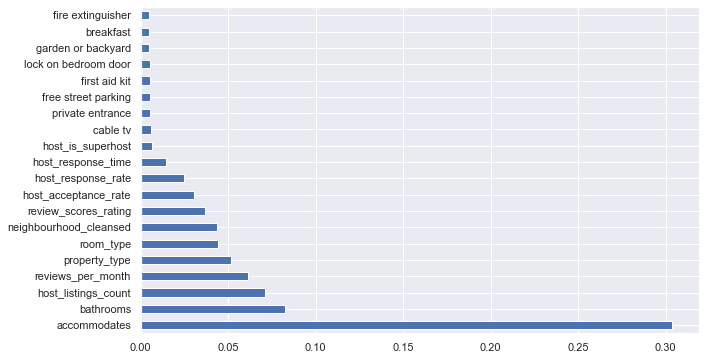

In [32]:
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

# LightGBM

## Train/Test w LightGBM

In [33]:
from lightgbm import LGBMRegressor


fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }
        
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
        
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

Training until validation scores don't improve for 20 rounds
[100]	valid's rmse: 84.5853
[200]	valid's rmse: 79.7195
[300]	valid's rmse: 78.2712
[400]	valid's rmse: 77.1324
[500]	valid's rmse: 76.55
[600]	valid's rmse: 76.2285
[700]	valid's rmse: 76.0958
Early stopping, best iteration is:
[691]	valid's rmse: 76.0848
R^2 test: 0.506


## Feature Importance of LightGBM

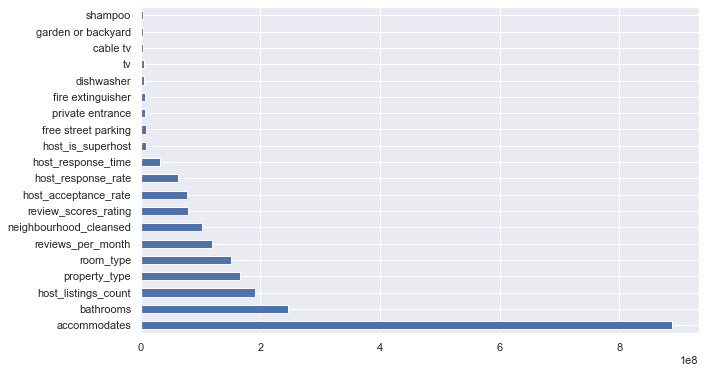

In [34]:
feat_imp = pd.Series(clf.feature_importances_, index=x.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

In [35]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = x.columns
coefs_df['coefs'] = clf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
8,accommodates,8.880521e+08
9,bathrooms,2.459005e+08
4,host_listings_count,1.907566e+08
6,property_type,1.661195e+08
7,room_type,1.517755e+08
11,reviews_per_month,1.198304e+08
5,neighbourhood_cleansed,1.027024e+08
10,review_scores_rating,7.863186e+07
2,host_acceptance_rate,7.708167e+07
1,host_response_rate,6.284454e+07


# Gradient Boosting

## Train/Test w Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingRegressor


gboost = GradientBoostingRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3)
gboost.fit(X_train, y_train)
y_train_pred = gboost.predict(X_train)
y_test_pred = gboost.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 75.853
R^2 test: 0.509


## Feature Importance of Gradient Boosting

In [37]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = gboost.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
8,accommodates,0.435758
9,bathrooms,0.095700
4,host_listings_count,0.089640
7,room_type,0.063200
6,property_type,0.058308
5,neighbourhood_cleansed,0.044930
11,reviews_per_month,0.044489
10,review_scores_rating,0.034930
1,host_response_rate,0.031340
2,host_acceptance_rate,0.026040


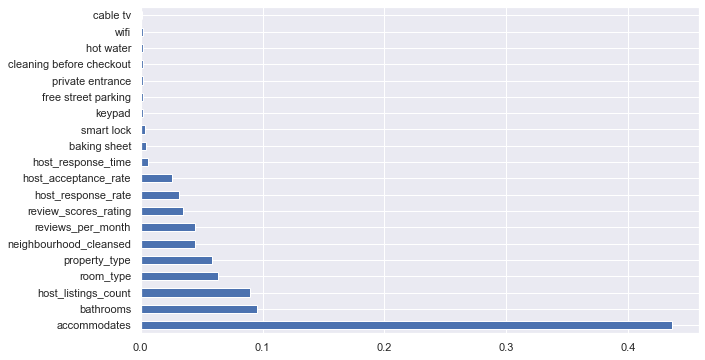

In [38]:
feat_imp = pd.Series(gboost.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

# XGBoost and its Feature Importance


Training MSE: 796.2729
Validation MSE: 6159.969
Validation RMSE: 78.4855

Training r2: 0.9382
Validation r2: 0.4742


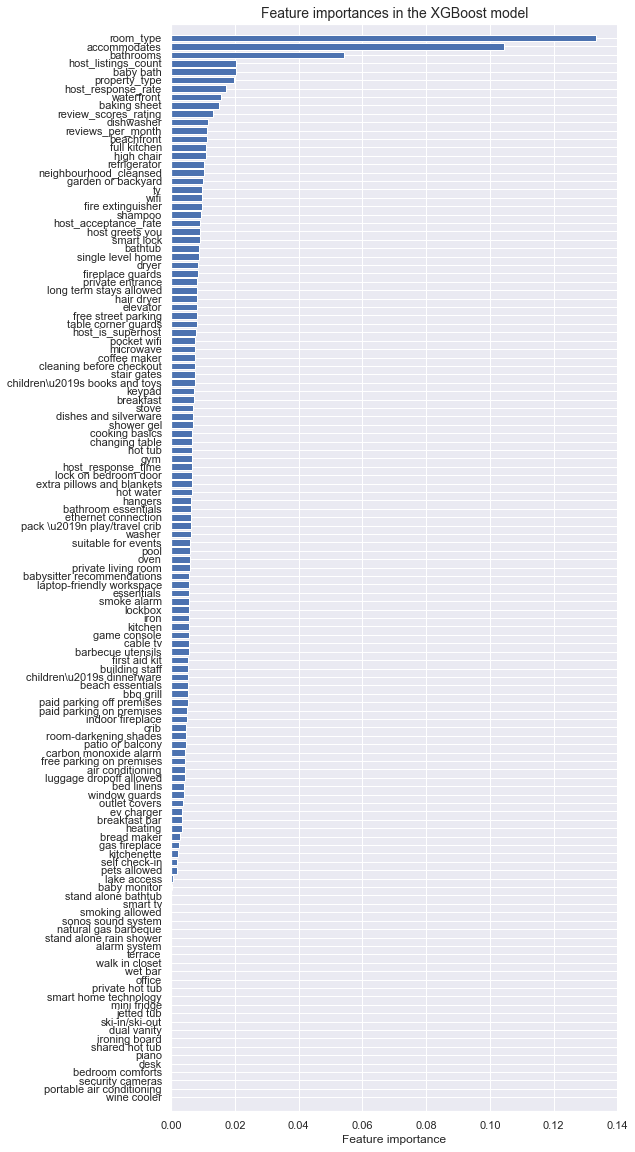

In [39]:
import xgboost as xgb

# Fitting the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg)**0.5,4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

# Neural Network Model

In [40]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(512, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Printing the model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

# Training the model
nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16384     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 247,297
Trainable params: 247,297
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
18/18 [==============================] - 1s 38ms/step - loss: 22944.2949 - mean_squared_error: 2294

Epoch 42/100
18/18 [==============================] - 0s 11ms/step - loss: 6368.9409 - mean_squared_error: 6368.9409 - val_loss: 7068.7383 - val_mean_squared_error: 7068.7383
Epoch 43/100
18/18 [==============================] - 0s 11ms/step - loss: 6455.4839 - mean_squared_error: 6455.4839 - val_loss: 7179.6978 - val_mean_squared_error: 7179.6978
Epoch 44/100
18/18 [==============================] - 0s 13ms/step - loss: 6374.9658 - mean_squared_error: 6374.9658 - val_loss: 7499.0073 - val_mean_squared_error: 7499.0073
Epoch 45/100
18/18 [==============================] - 0s 12ms/step - loss: 6071.5918 - mean_squared_error: 6071.5918 - val_loss: 8528.2344 - val_mean_squared_error: 8528.2344
Epoch 46/100
18/18 [==============================] - 0s 13ms/step - loss: 6813.3945 - mean_squared_error: 6813.3945 - val_loss: 7184.2246 - val_mean_squared_error: 7184.2246
Epoch 47/100
18/18 [==============================] - 0s 11ms/step - loss: 5988.2358 - mean_squared_error: 5988.2358 - val_lo

Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 5344.1670 - mean_squared_error: 5344.1670 - val_loss: 7081.2700 - val_mean_squared_error: 7081.2700
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 4947.8535 - mean_squared_error: 4947.8535 - val_loss: 7609.8545 - val_mean_squared_error: 7609.8545
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 5020.2368 - mean_squared_error: 5020.2368 - val_loss: 7116.8232 - val_mean_squared_error: 7116.8232
Epoch 92/100
18/18 [==============================] - 0s 9ms/step - loss: 5085.2368 - mean_squared_error: 5085.2368 - val_loss: 7522.4355 - val_mean_squared_error: 7522.4355
Epoch 93/100
18/18 [==============================] - 0s 15ms/step - loss: 6071.7188 - mean_squared_error: 6071.7188 - val_loss: 7830.2773 - val_mean_squared_error: 7830.2773
Epoch 94/100
18/18 [==============================] - 0s 9ms/step - loss: 5487.2998 - mean_squared_error: 5487.2998 - val_loss: 

In [41]:
y_test_pred = nn2.predict(X_test)
y_train_pred = nn2.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred)**0.5,4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 5268.2338
Validation MSE: 7926.8791
Validation RMSE: 89.033

Training r2: 0.5912
Validation r2: 0.3234


# Distribution of Numeric Columns

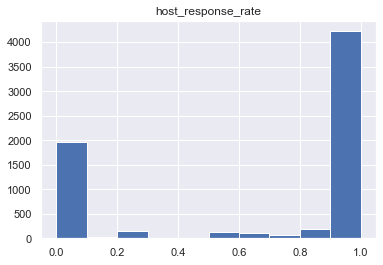

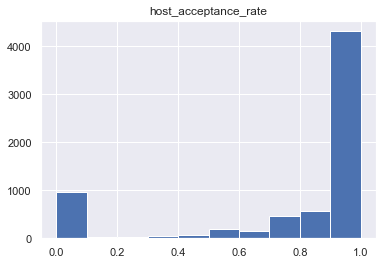

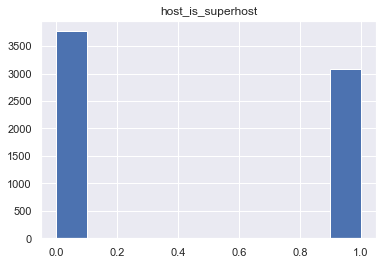

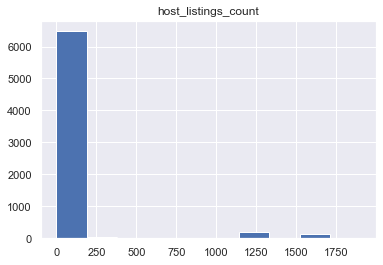

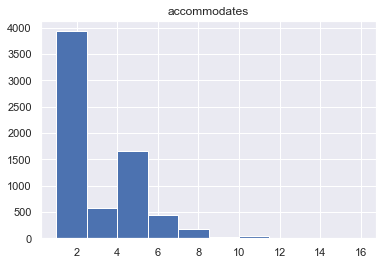

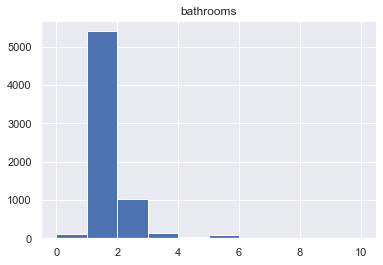

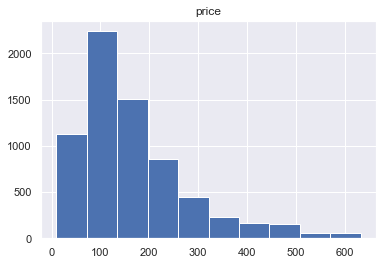

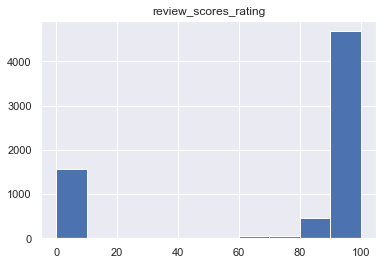

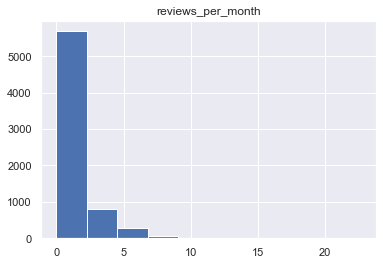

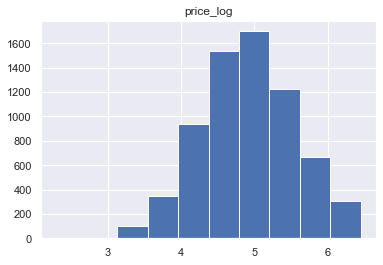

In [42]:
new_numeric_cols = []
for col in new_SF_df.columns: 
    if col in numeric_columns:
        new_numeric_cols.append(col)
        try:      
            new_SF_df[col] = pd.to_numeric(new_SF_df[col]) 
            new_SF_df.hist(column=col)
        except ValueError:
            print('This column can not be represented as a histogram')

# Standardizing Features

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train.values) # only scaler.fit on train set
X_stand_train = scaler.transform(X_train.values)
X_stand_test = scaler.transform(X_test.values)

# Random Forest after Standardization

In [44]:
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_stand_train, y_train)
y_train_pred = rf.predict(X_stand_train)
y_test_pred = rf.predict(X_stand_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 79.575
R^2 test: 0.460


# LightGBM after Standardization

In [45]:
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_stand_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }
        
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
        
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_stand_train, y_train.values, **fit_params)
y_pred = clf.predict(X_stand_test)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

Training until validation scores don't improve for 20 rounds
[100]	valid's rmse: 84.5853
[200]	valid's rmse: 79.7195
[300]	valid's rmse: 78.2712
[400]	valid's rmse: 77.1324
[500]	valid's rmse: 76.55
[600]	valid's rmse: 76.2285
[700]	valid's rmse: 76.0958
Early stopping, best iteration is:
[691]	valid's rmse: 76.0848
R^2 test: 0.506


# LassoCV Model

In [46]:
from sklearn.linear_model import Lasso, LassoCV

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_stand_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [47]:
# R2 of Training set
lasso_model.score(X_stand_train,y_train)

# Predict model on test data
y_pred = lasso_model.predict(X_stand_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 64.361
RMSE test: 88.652
R^2 test: 0.329


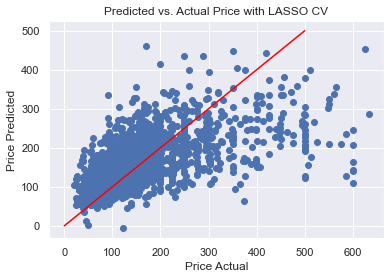

In [48]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with LASSO CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual');

# RidgeCV Model

In [49]:
from sklearn.linear_model import RidgeCV

reg_params = 10.**np.linspace(-10, 5, 10)
ridge_model = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
ridge_model.fit(X_stand_train, y_train)

RidgeCV(alphas=array([1.00000000e-10, 4.64158883e-09, 2.15443469e-07, 1.00000000e-05,
       4.64158883e-04, 2.15443469e-02, 1.00000000e+00, 4.64158883e+01,
       2.15443469e+03, 1.00000000e+05]),
        cv=5)

In [50]:
# R2 of Training set
ridge_model.score(X_stand_train,y_train)

# Predict model on test data
y_pred = ridge_model.predict(X_stand_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 65.128
RMSE test: 89.579
R^2 test: 0.315


Text(0.5, 0, 'Price Actual')

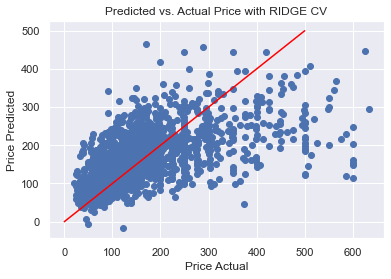

In [51]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with RIDGE CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual')